# Preparation Work

In [1]:
#!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 468 (delta 195), reused 213 (delta 131), pack-reused 162 (from 1)
Receiving objects: 100% (468/468), 280.62 KiB | 5.61 MiB/s, done.
Resolving deltas: 100% (236/236), done.


In [2]:
cd /home/yl2672496l/Yue/code/llm/lag-llama

/home/yl2672496l/Yue/code/llm/lag-llama


In [14]:
# import sys
# !{sys.executable} -m pip install -r requirements.txt --quiet

In [7]:
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /home/yl2672496l/Yue/code/llm/lag-llama

lag-llama.ckpt: 100%|██████████████████████| 29.5M/29.5M [00:00<00:00, 42.9MB/s]
Download complete. Moving file to /home/yl2672496l/Yue/code/llm/lag-llama/lag-llama.ckpt
/home/yl2672496l/Yue/code/llm/lag-llama/lag-llama.ckpt


In [3]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

for i in range(num_gpus):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")

Number of GPUs available: 1
GPU 0: NVIDIA A30


# Lag-Llama prediction function

We create a function for Lag-Llama inference that we can reuse for all different types of dataset below. This function returns the predictions for the given prediction horizon. The forecast will be of shape (`num_samples`, `prediction_length`), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.


In [7]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

# Read data

In [8]:
import numpy as np

In [12]:
import os
os.getcwd()

'/home/yl2672496l/Yue/code/llm/lag-llama'

In [13]:
traffic_data = pd.read_csv('../../GD030A_S.csv')

In [14]:
# Define the recover_timestamp function
def recover_timestamp(data):
    # Combine 'date' and 'time' to form a datetime column
    data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'].astype(str) + ':00', format='%Y-%m-%d %H:%M')

    # Set 'datetime' as index
    data = data.set_index('datetime')

    # Create a complete range of timestamps with hourly frequency
    full_time_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')

    # Reindex the data to include all timestamps, filling missing rows with NaN
    data_full = data.reindex(full_time_range)

    return data_full

In [15]:
# Apply the recover_timestamp function to recover the full time series
traffic_full = recover_timestamp(traffic_data)
traffic_full

,date,time,flow
2019-10-01 00:00:00,2019-10-01,0.0,15.0
2019-10-01 01:00:00,2019-10-01,1.0,9.0
2019-10-01 02:00:00,2019-10-01,2.0,9.0
2019-10-01 03:00:00,2019-10-01,3.0,7.0
2019-10-01 04:00:00,2019-10-01,4.0,9.0
...,...,...,...
2023-09-30 19:00:00,2023-09-30,19.0,129.0
2023-09-30 20:00:00,2023-09-30,20.0,119.0
2023-09-30 21:00:00,2023-09-30,21.0,106.0
2023-09-30 22:00:00,2023-09-30,22.0,88.0


In [16]:
train_set = traffic_full['2022-06-03 00:00:00':'2023-03-31 23:00:00']
valid_set = traffic_full['2023-04-01 00:00:00':'2023-06-30 23:00:00']
test_set = traffic_full['2023-07-01 00:00:00':]
print('Proportion of train_set : {:.4f}'.format(len(train_set)/len(traffic_full['2022-06-03 00:00:00':])))
print('Proportion of valid_set : {:.4f}'.format(len(valid_set)/len(traffic_full['2022-06-03 00:00:00':])))
print('Proportion of test_set : {:.4f}'.format(len(test_set)/len(traffic_full['2022-06-03 00:00:00':])))

Proportion of train_set : 0.6227
Proportion of valid_set : 0.1876
Proportion of test_set : 0.1897


In [17]:
import pandas as pd
import numpy as np

def create_sequences(data, input_length, forecast_horizon):
    """
    Creates sequences for time series data, excluding any sequences containing NaN values.

    Parameters:
    - data: pandas DataFrame containing the data. Must include the 'flow' column.
    - input_length: int, number of past time steps to include in each input sequence.
    - forecast_horizon: int, number of future steps to predict.

    Returns:
    - sequences_df: pandas DataFrame containing all sequences with input lags and output leads,
                    and an 'item_id' column to separate each sequence.
    """
    sequences = []
    item_id = 0  # To assign unique ID to each sequence

    for i in range(input_length, len(data) - forecast_horizon + 1):
        # Extract the input sequence
        X_seq = data.iloc[i - input_length:i]['flow'].values
        # Extract the target sequence
        y_seq = data.iloc[i:i + forecast_horizon]['flow'].values

        # Check for NaN values in the input sequence and target sequence
        if not np.isnan(X_seq).any() and not np.isnan(y_seq).any():
            # Convert X_seq and y_seq to DataFrames
            x_df = pd.DataFrame({'target_flow': X_seq})
            y_df = pd.DataFrame({'target_flow': y_seq})

            # Concatenate X_df and y_df
            seq_df = pd.concat([x_df, y_df], ignore_index=True)

            # Add 'item_id' column
            seq_df['item_id'] = item_id
            item_id += 1  # Increment item_id

            # Append to list
            sequences.append(seq_df)
        else:
            # Optionally, log or count the skipped sequences
            pass  # Simply skip sequences with NaNs

    # Concatenate all sequences into one DataFrame
    sequences_df = pd.concat(sequences)
    sequences_df['item_id'] = sequences_df['item_id'].astype('object')
    sequences_df['target_flow'] = sequences_df['target_flow'].astype('float32')

    return sequences_df


In [18]:
# Define Input Sequence Lengths
input_lengths = [32,64,128,256,512]

In [37]:
from collections import defaultdict
data_dict = defaultdict(dict)

for length in input_lengths:
    print(f"Processing input length: {length}")

    # Create sequences with forecast_horizon=6
    train = create_sequences(train_set, length, forecast_horizon=6)
    val = create_sequences(valid_set, length, forecast_horizon=6)
    test = create_sequences(test_set, length, forecast_horizon=6)

    # Store in the dictionary
    data_dict[length]['train'] = train
    data_dict[length]['val'] = val
    data_dict[length]['test'] = test

    # Print shapes and ensure no NaNs
    print(f"  train shape: {train.index.max()+1}, {len(train.item_id.unique())}")
    print(f"  val shape: {val.index.max()+1}, {len(val.item_id.unique())}")
    print(f"  test shape: {test.index.max()+1}, {len(test.item_id.unique())}\n")

Processing input length: 32
  train shape: 38, 7121
  val shape: 38, 1975
  test shape: 38, 1679

Processing input length: 64
  train shape: 70, 7025
  val shape: 70, 1847
  test shape: 70, 1540

Processing input length: 128
  train shape: 134, 6833
  val shape: 134, 1591
  test shape: 134, 1284

Processing input length: 256
  train shape: 262, 6449
  val shape: 262, 1079
  test shape: 262, 772

Processing input length: 512
  train shape: 518, 5681
  val shape: 518, 317
  test shape: 518, 231



# Zero-shot

In [40]:
# Create the Pandas
dataset = PandasDataset.from_long_dataframe(data_dict[32]['test'], target="target_flow", item_id="item_id")

backtest_dataset = dataset
prediction_length = 6  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [41]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

/tmp/ipykernel_1374819/223013842.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab 

In [45]:
len(forecasts), forecasts[0].samples.shape

(1679, (100, 6))

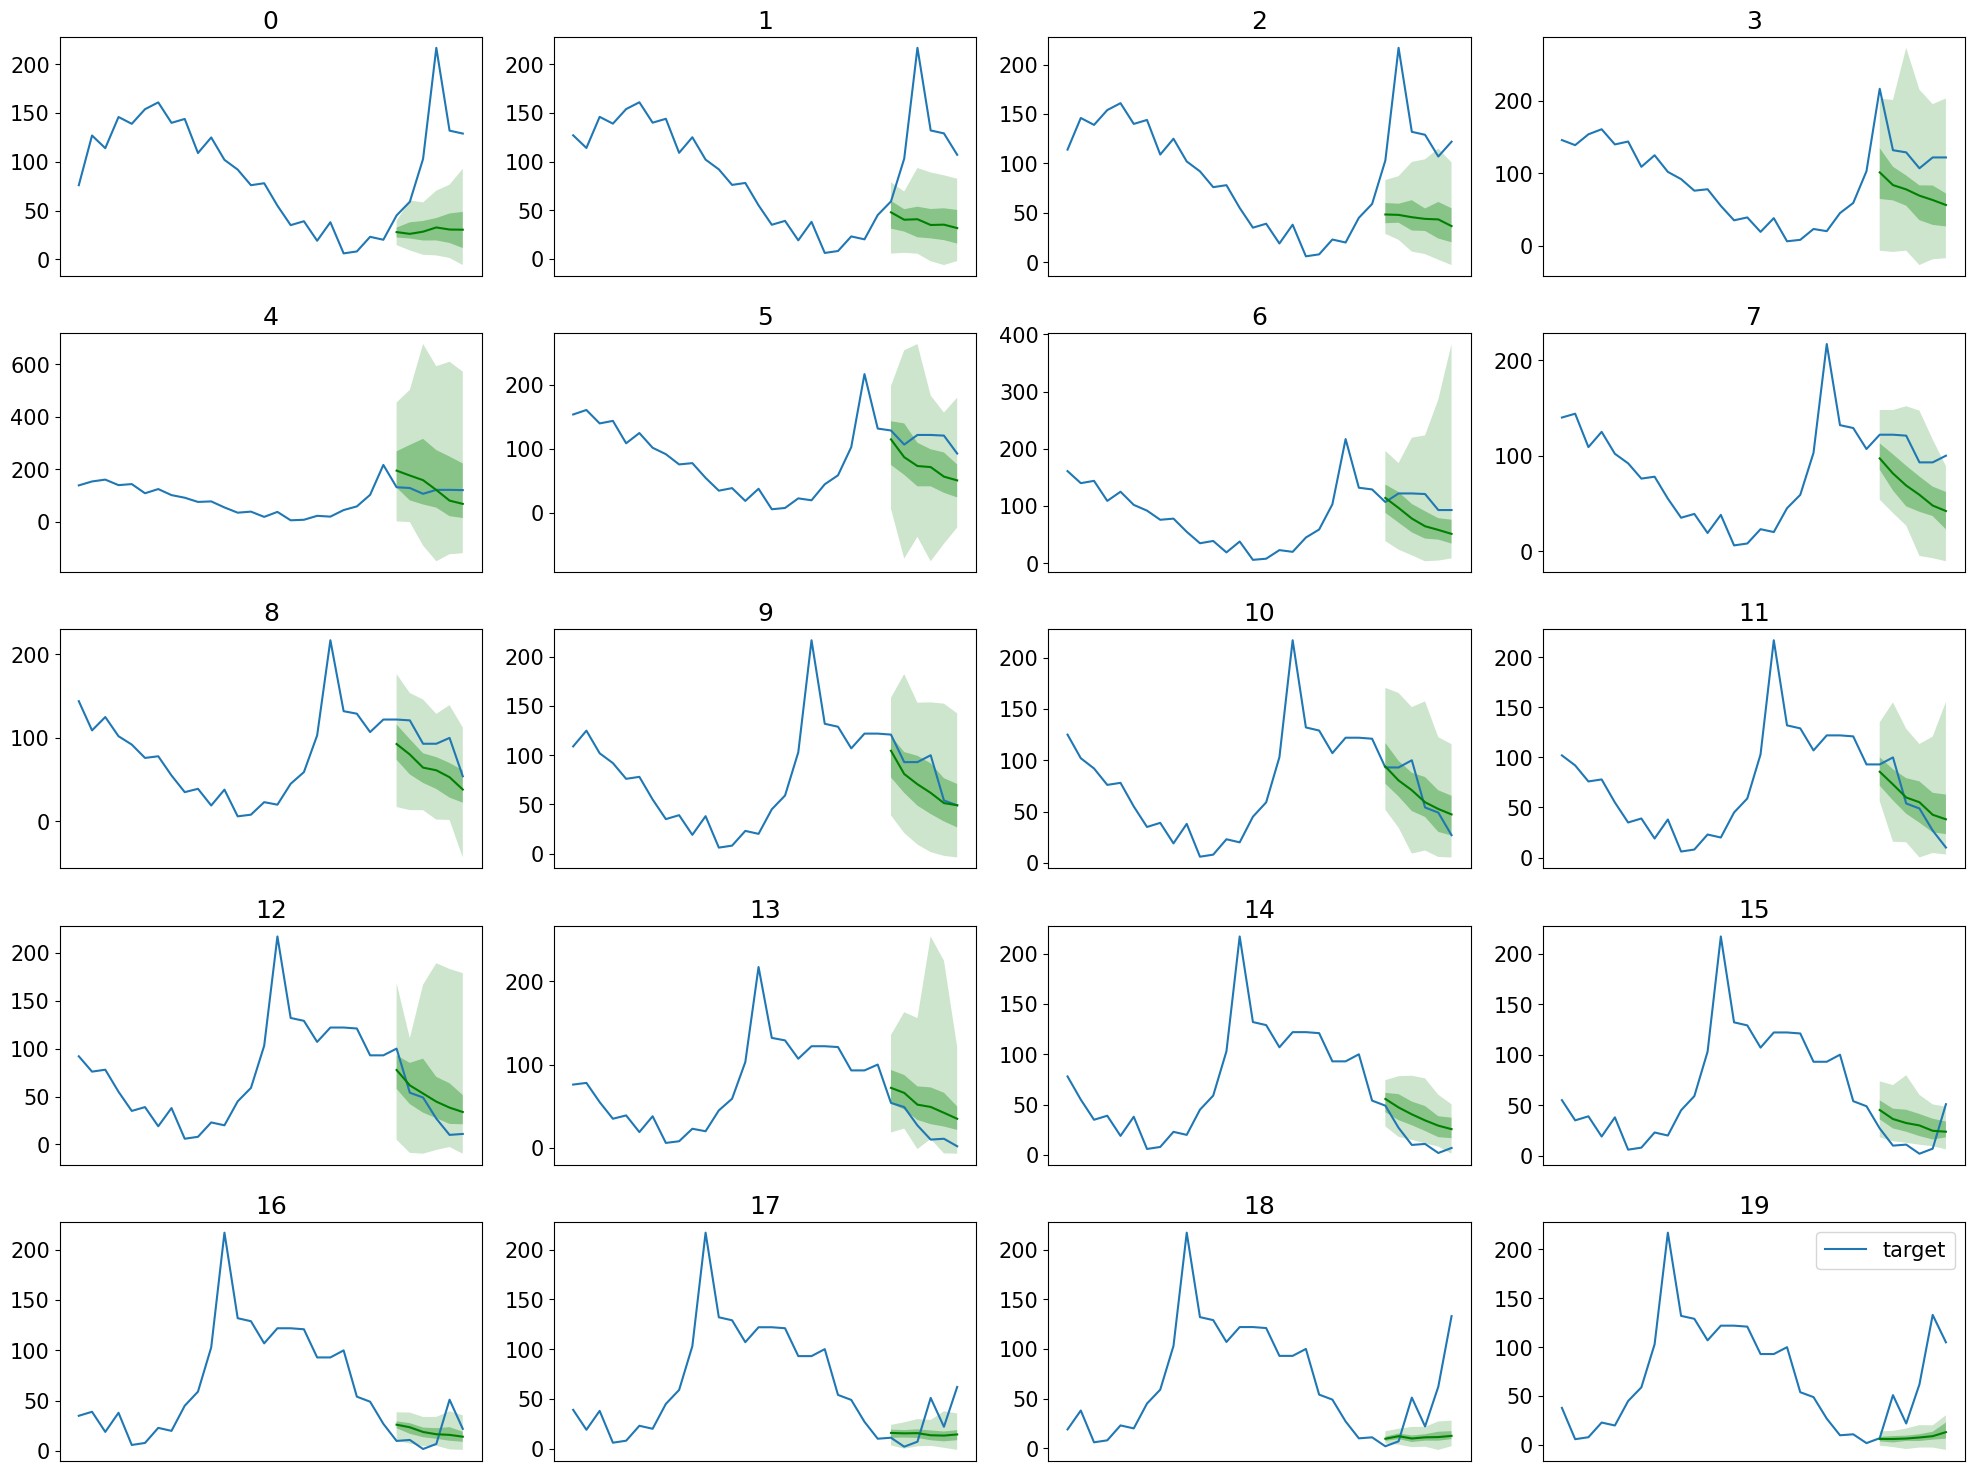

In [50]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 20):
    ax = plt.subplot(5, 4, idx+1)

    plt.plot(ts[-5 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [51]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 1679it [00:00, 3102.14it/s]
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` 

In [52]:
agg_metrics

{'MSE': 5482.475781154273,
 'abs_error': 506830.8017501831,
 'abs_target_sum': 1348624.0,
 'abs_target_mean': 133.87174905697836,
 'seasonal_error': 21.767238563661163,
 'MASE': 2.3655290625230068,
 'MAPE': 0.4219384523541629,
 'sMAPE': 0.40942489677522065,
 'MSIS': 35.265178332580746,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 218094.9734130859,
 'Coverage[0.1]': 0.045364304149295216,
 'QuantileLoss[0.2]': 308045.9010971069,
 'Coverage[0.2]': 0.12030970815961882,
 'QuantileLoss[0.3]': 384631.0048316955,
 'Coverage[0.3]': 0.222255310700814,
 'QuantileLoss[0.4]': 450251.1748374939,
 'Coverage[0.4]': 0.33045463569585065,
 'QuantileLoss[0.5]': 506830.8014469147,
 'Coverage[0.5]': 0.44480841770895374,
 'QuantileLoss[0.6]': 551333.059728241,
 'Coverage[0.6]': 0.54526503871352,
 'QuantileLoss[0.7]': 597299.9610603333,
 'Coverage[0.7]': 0.659221758983522,
 'QuantileLoss[0.8]': 607486.5164611816,
 'Coverage[0.8]': 0.7553107008139764,
 'QuantileLoss[0.9]': 504715.98307647696,
 'Cov

# Fine-tuning

In [59]:
# Create the Pandas
dataset_train = PandasDataset.from_long_dataframe(data_dict[32]['train'], target="target_flow", item_id="item_id")
dataset_test = PandasDataset.from_long_dataframe(data_dict[32]['test'], target="target_flow", item_id="item_id")
context_length = 32
prediction_length = 6  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda") 

In [57]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

/tmp/ipykernel_1374819/1203499310.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)


In [58]:
predictor = estimator.train(dataset_train, cache_data=True, shuffle_buffer_length=1000)

/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
GPU available: True (cuda), u

Epoch 0: |                              | 50/? [00:05<00:00,  9.25it/s, v_num=0]

Epoch 0, global step 50: 'train_loss' reached 4.70311 (best 4.70311), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |                              | 50/? [00:04<00:00, 10.76it/s, v_num=0]

Epoch 1, global step 100: 'train_loss' was not in top 1


Epoch 2: |                              | 50/? [00:03<00:00, 15.79it/s, v_num=0]

Epoch 2, global step 150: 'train_loss' reached 4.60395 (best 4.60395), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |                              | 50/? [00:02<00:00, 20.57it/s, v_num=0]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: |                              | 50/? [00:02<00:00, 20.78it/s, v_num=0]

Epoch 4, global step 250: 'train_loss' was not in top 1


Epoch 5: |                              | 50/? [00:02<00:00, 21.07it/s, v_num=0]

Epoch 5, global step 300: 'train_loss' reached 4.52025 (best 4.52025), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_0/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |                              | 50/? [00:02<00:00, 20.96it/s, v_num=0]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |                              | 50/? [00:02<00:00, 22.86it/s, v_num=0]

Epoch 7, global step 400: 'train_loss' reached 4.36671 (best 4.36671), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_0/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |                              | 50/? [00:02<00:00, 21.05it/s, v_num=0]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |                              | 50/? [00:02<00:00, 21.49it/s, v_num=0]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |                             | 50/? [00:02<00:00, 19.75it/s, v_num=0]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |                             | 50/? [00:02<00:00, 20.47it/s, v_num=0]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |                             | 50/? [00:02<00:00, 20.16it/s, v_num=0]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |                             | 50/? [00:02<00:00, 21.55it/s, v_num=0]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |                             | 50/? [00:02<00:00, 22.45it/s, v_num=0]

Epoch 14, global step 750: 'train_loss' reached 4.32488 (best 4.32488), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_0/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |                             | 50/? [00:02<00:00, 21.49it/s, v_num=0]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |                             | 50/? [00:02<00:00, 19.65it/s, v_num=0]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |                             | 50/? [00:02<00:00, 20.49it/s, v_num=0]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |                             | 50/? [00:02<00:00, 20.69it/s, v_num=0]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |                             | 50/? [00:02<00:00, 20.70it/s, v_num=0]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |                             | 50/? [00:02<00:00, 20.13it/s, v_num=0]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |                             | 50/? [00:02<00:00, 19.63it/s, v_num=0]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |                             | 50/? [00:02<00:00, 20.56it/s, v_num=0]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |                             | 50/? [00:02<00:00, 20.96it/s, v_num=0]

Epoch 23, global step 1200: 'train_loss' reached 4.29546 (best 4.29546), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_0/checkpoints/epoch=23-step=1200.ckpt' as top 1


Epoch 24: |                             | 50/? [00:02<00:00, 21.44it/s, v_num=0]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |                             | 50/? [00:02<00:00, 20.28it/s, v_num=0]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |                             | 50/? [00:02<00:00, 21.55it/s, v_num=0]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |                             | 50/? [00:02<00:00, 20.98it/s, v_num=0]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |                             | 50/? [00:02<00:00, 20.32it/s, v_num=0]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |                             | 50/? [00:02<00:00, 20.74it/s, v_num=0]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |                             | 50/? [00:02<00:00, 21.47it/s, v_num=0]

Epoch 30, global step 1550: 'train_loss' reached 4.23034 (best 4.23034), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_0/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |                             | 50/? [00:02<00:00, 20.58it/s, v_num=0]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |                             | 50/? [00:02<00:00, 21.83it/s, v_num=0]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |                             | 50/? [00:02<00:00, 20.67it/s, v_num=0]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |                             | 50/? [00:02<00:00, 22.27it/s, v_num=0]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |                             | 50/? [00:02<00:00, 20.73it/s, v_num=0]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |                             | 50/? [00:02<00:00, 21.17it/s, v_num=0]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |                             | 50/? [00:02<00:00, 20.42it/s, v_num=0]

Epoch 37, global step 1900: 'train_loss' reached 4.16768 (best 4.16768), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_0/checkpoints/epoch=37-step=1900.ckpt' as top 1


Epoch 38: |                             | 50/? [00:02<00:00, 20.54it/s, v_num=0]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |                             | 50/? [00:02<00:00, 20.66it/s, v_num=0]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |                             | 50/? [00:02<00:00, 19.49it/s, v_num=0]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |                             | 50/? [00:02<00:00, 20.49it/s, v_num=0]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |                             | 50/? [00:02<00:00, 21.01it/s, v_num=0]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |                             | 50/? [00:02<00:00, 21.30it/s, v_num=0]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |                             | 50/? [00:02<00:00, 20.04it/s, v_num=0]

Epoch 44, global step 2250: 'train_loss' reached 4.11857 (best 4.11857), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_0/checkpoints/epoch=44-step=2250.ckpt' as top 1


Epoch 45: |                             | 50/? [00:02<00:00, 20.45it/s, v_num=0]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |                             | 50/? [00:02<00:00, 19.31it/s, v_num=0]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |                             | 50/? [00:02<00:00, 20.47it/s, v_num=0]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |                             | 50/? [00:02<00:00, 21.17it/s, v_num=0]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |                             | 50/? [00:02<00:00, 21.00it/s, v_num=0]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |                             | 50/? [00:02<00:00, 20.96it/s, v_num=0]


/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [60]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset_test,
        predictor=predictor,
        num_samples=num_samples
    )

In [61]:
forecast_it

<generator object PyTorchPredictor.predict at 0x76730eef3b30>